In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import shap

In [27]:
# Replace 'your_file.txt' with the path to your actual file
file_path = 'C:\\Users\\mcorn\\Documents\\CSE_6242\\Project\\fnma_sf2022c_loans.txt'

# For a TSV file, you would use sep='\t'
df = pd.read_csv(file_path, delim_whitespace=True, header=None)

In [3]:
#column names from Aaron's code
colnames = ["enterprise_flag",
                "record_num",
                "state_fips_code",
                "msa_code",
                "county_fips_code",
                "census_tract", 
                "tract_pct_minority",
                "tract_median_income",
                "local_median_income",
                "tract_income_ratio",
                "borrower_income",
                "local_median_family_income",
                "borrower_income_ratio",
                "upb",
                "purpose",
                "federal_guarantee",
                "num_borrowers",
                "first_time_buyer",
                "borrower_race_1", 
                "borrower_race_2",
                "borrower_race_3",
                "borrower_race_4",
                "borrower_race", # use this
                "borrower_ethnicity",
                "co-borrower_race_1", 
                "co-borrower_race_2",
                "co-borrower_race_3",
                "co-borrower_race_4",
                "co-borrower_race",
                "co-borrower_ethnicity",
                "borrower_gender",
                "co-borrower_gender",
                "borrower_age",
                "co-borrower_age",
                "occupancy_code",
                "rate_spread",
                "HOEPA_status",
                "property_type",
                "lien_status",
                "borrower_62+",
                "co-borrower_62+",
                "ltv",
                "date_of_note",
                "term_at_orig",
                "num_units",
                "rate_at_orig",
                "note_amount",
                "preapproval",
                "application_channel",
                "AUS_name",
                "borrower_credit_model",
                "co-borrower_credit_model",
                "dti",
                "discount_points",
                "intro_rate_period",
                "land_property_interest",
                "property_value",
                "rural_tract",
                "mississippi_delta_county",
                "mid_appalachia_county",
                "persistent_poverty_county",
                "area_concentrated_poverty",
                "high_opportunity_area"]


In [4]:
#rename column names in df
df.columns = colnames

In [8]:
#function to convert dti to categorical variable

def map_dti_to_label(dti):
    if dti in [10, 20, 30]:
        return '< 35%'
    elif 36 <= dti <= 98:
        return '> 35%'  
    elif dti == 99:
        return 'Not available'
    else:
        return 'Other'

In [9]:
#apply to dataset and create new column
df['DTI_Category'] = df['dti'].apply(map_dti_to_label)

In [11]:
#DTI Category distribution
df['DTI_Category'].value_counts()

DTI_Category
> 35%            1137548
< 35%             899463
Not available          4
Name: count, dtype: int64

In [15]:
#remove instances where DTI is NA from dataset 
pred_df = df[df['DTI_Category'] != 'Not available']

In [16]:
#label encode DTI Category
categories_order = ['< 35%' , '> 35%']

label_encoder = LabelEncoder()
label_encoder.fit(categories_order)

pred_df['DTI_Category_encoded'] = label_encoder.transform(pred_df['DTI_Category'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [17]:
#extract response and explanatory variables from full dataset
pred_df_clean = pred_df[['DTI_Category_encoded','tract_pct_minority','local_median_income','borrower_income','property_value','ltv','borrower_race_1','borrower_age','borrower_ethnicity','borrower_gender','purpose','borrower_income_ratio','first_time_buyer','occupancy_code','state_fips_code']]

In [18]:
#convert categorical fields to binary
pred_df_clean = pd.get_dummies(pred_df_clean, columns=['borrower_race_1','borrower_age','borrower_ethnicity','borrower_gender','purpose','first_time_buyer','occupancy_code','state_fips_code'], drop_first = True)
pred_df_clean = pred_df_clean.astype(int)

In [19]:
#drop N/As
pred_df_clean = pred_df_clean.dropna()

In [20]:
#sample 10% of the dataset - an assumption we can revisit, just trying to make the random forset model run faster for now
pred_df_clean = pred_df_clean.sample(frac=0.10, random_state=42)

In [21]:
#split data into x, y
y = pred_df_clean['DTI_Category_encoded']
X = pred_df_clean.drop(columns=['DTI_Category_encoded'])

In [22]:
#fit random forest model - no changes to hyperparameters for RF
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

random_forest.fit(X_train, y_train)

predictions = random_forest.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, predictions))

Accuracy: 0.6948709892785611
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.62      0.64     22470
           1       0.72      0.75      0.73     28456

    accuracy                           0.69     50926
   macro avg       0.69      0.69      0.69     50926
weighted avg       0.69      0.69      0.69     50926



In [23]:
#extract feature importance and create dataframe
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': random_forest.feature_importances_})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


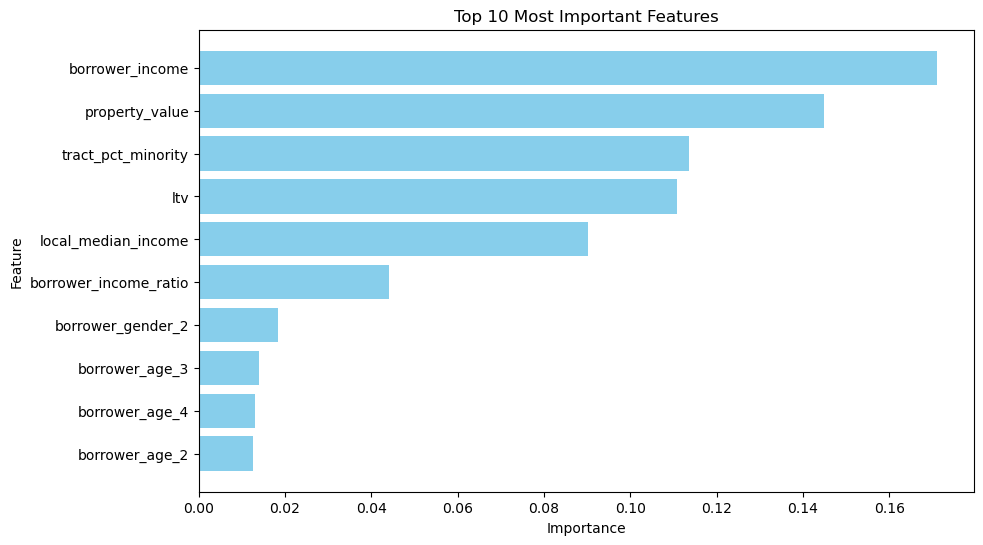

In [24]:
# Select the top 10 most important features
top_features = feature_importance_df.head(10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features')
plt.gca().invert_yaxis()  
plt.show()

In [34]:
##LTV regression example

In [28]:
pred_df_ltv = pred_df[['DTI_Category','tract_pct_minority','local_median_income','borrower_income','property_value','ltv','borrower_race_1','borrower_age','borrower_ethnicity','borrower_gender','purpose','borrower_income_ratio','first_time_buyer','occupancy_code','state_fips_code']]

In [29]:
#convert categorical fields to binary
pred_df_ltv = pd.get_dummies(pred_df_ltv, columns=['DTI_Category','borrower_race_1','borrower_age','borrower_ethnicity','borrower_gender','purpose','first_time_buyer','occupancy_code','state_fips_code'], drop_first = True)
pred_df_ltv = pred_df_ltv.astype(int)

In [30]:
#drop N/As
pred_df_ltv = pred_df_ltv.dropna()

In [31]:
#sample 10% of the dataset - an assumption we can revisit, just trying to make the random forset model run faster for now
pred_df_ltv = pred_df_ltv.sample(frac=0.10, random_state=42)

In [32]:
#split data into x, y
y = pred_df_ltv['ltv']
X = pred_df_ltv.drop(columns=['ltv'])

In [33]:
#train random forest regressor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)

predictions = random_forest.predict(X_test)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("MSE:", mse)
print("RMSE:", rmse)
print("R^2:", r2)

MSE: 162.19292486129706
RMSE: 12.735498610627582
R^2: 0.563165173085545


In [35]:
#extract feature importance and create dataframe
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': random_forest.feature_importances_})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


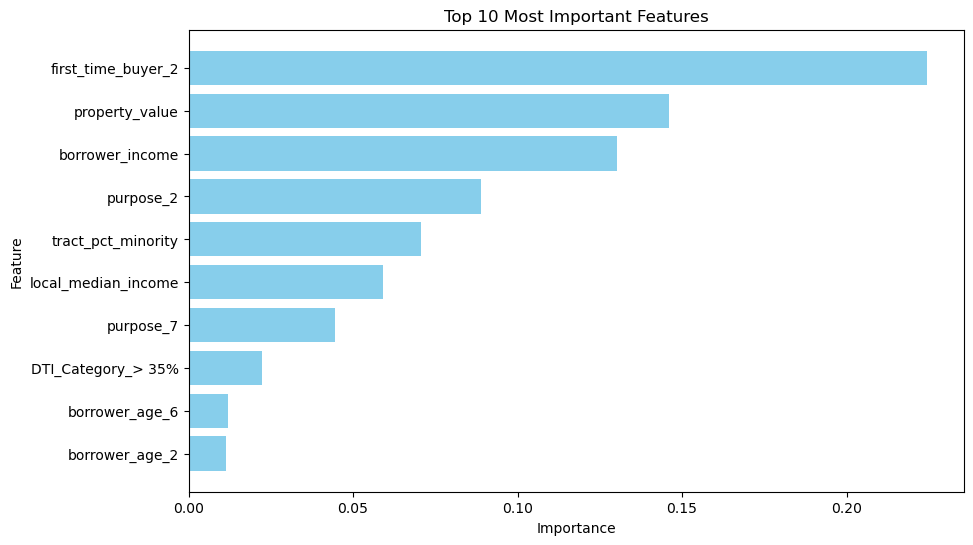

In [36]:
# Select the top 10 most important features
top_features = feature_importance_df.head(10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features')
plt.gca().invert_yaxis()  
plt.show()